In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
# from bo_methods_lib.bo_methods_lib.bo_functions_generic import gen_theta_set, clean_1D_arrays
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = False
param_name_str = "t1t2"
cs_name_val = 1
project = signac.get_project()
df = pd.DataFrame()
for meth_name_val in meth_name_str_list:
    df_piece, name_cs_str, theta_true = get_study_data_signac(project, cs_name_val, param_name_str, meth_name_val, 
                                                              study_id, save_csv)
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]
print(theta_true)

[ 1. -1.]


In [3]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
df_best

# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
11,5,1,5.342819,0.666667,0.0,"[-1.1923314387327575, 1.2550420118452932]",0.86575,0.078749,"[1.0622882964925582, -0.9657215500034723]",0.078749,"[1.0622882964925582, -0.9657215500034723]",0.14952,3,A1,2,0.299039,0.071097
165,7,1,1.675753,1.0,0.0,"[-0.12469795110750015, 1.8446633771315404]",1.337255,-1.118795,"[0.9078567554482146, -0.9156740615532917]",-1.118795,"[0.9078567554482146, -0.9156740615532917]",0.107567,1,B1,2,0.215134,0.124905
274,3,4,0.000002,2.0,0.000002,"[1.0001750084083774, -0.9997719454291544]",0.0,0.000001,"[1.0001041838227045, -0.9998630819205805]",0.000001,"[1.0001041838227045, -0.9998630819205805]",1.737641,4,A2,5,8.688207,0.000172
2137,13,99,-20.831986,0.5,4.253996,"[1.000003510958464, -0.9999952747577525]",-23.00006,-21.056092,"[1.0000037983732255, -0.9999958961327475]",-21.056092,"[1.0000037983732255, -0.9999958961327475]",73.386999,3,B2,100,7338.699937,0.000006
5271,1,1,5.342819,1.124104,0.0,"[-0.9023643249400515, 1.009907260734813]",0.000554,0.006628,"[1.025695915986367, -0.9991365280015173]",0.006628,"[1.025695915986367, -0.9991365280015173]",15.352817,4,C2,2,30.705635,0.025710


In [4]:
file_path_list = []
project = signac.get_project()
param_name_str = "t1t2"
cs_name_val = 1
meth_name_str_list = [1, 2, 3, 4, 5]

for meth_name_val in meth_name_str_list:
    meth_name = Method_name_enum(meth_name_val)
    cs_name_enum = CS_name_enum(cs_name_val) 
    #Get best ep data from Results path if possible
    path_name = "Results/ep_study/" + cs_name_enum.name + "/" + param_name_str + "/ep_study_best.csv"
    if os.path.exists(path_name):
        df_ep_best = pd.read_csv(path_name, header = 0, index_col = 0)
    #If there is no results path infer it directly from the jobs
    else:
        df_ep, cs_name, theta_true = get_study_data_signac(project, cs_name_val, param_name_str, meth_name_val,
                                                           "ep", save_csv = False) 
        df_ep_best = get_best_data(df_ep, "ep", cs_name, theta_true, date_time_str = None, save_csv = False)

    #Set ep enum val to the best one for that cs and method
    best_ep_enum_val = int(df_best.loc[df_best['BO Method'] == meth_name.name, 'EP Method Val'].iloc[0])

    #Get all jobs with that ep enum val
    jobs = project.find_jobs({"cs_name_val": cs_name_val, "meth_name_val" : meth_name_val, "ep_enum_val": best_ep_enum_val, "sep_fact" : 1})
    for job in jobs:
        file_path_list.append(job.fn("BO_Results.gz"))

In [5]:
#Make heat maps
project = signac.get_project()
meth_name_str_list = [1, 2, 3, 4, 5]
param_name_str = "t1t2"
cs_name_val = 1
num_val_pts = 20

title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_path = None
cmap = "autumn"
log_data = True

#Get Best Data from ep experiment
df_best_path = "Results/ep_study/" + cs_name_enum.name + "/" + param_name_str + "/ep_study_best.csv"
df_best = pd.read_csv(df_best_path, header = 0, index_col = 0)

run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))
meth_names = list(df_best["BO Method"])

for i in range(len(file_path_list)):    
    run_num = run_num_list[i]
    bo_iter = bo_iter_list[i]
    file_path = file_path_list[i]

    dim_theta = sum(1 for char in param_name_str if char.isalpha())
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    pair = 0
    
    analysis_list = analyze_heat_maps(file_path, run_num, bo_iter, pair, log_data)
    sim_sse_var_ei, test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, idcs_to_plot = analysis_list
    sse_sim, sse_mean, sse_var, ei = sim_sse_var_ei

    title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
    title = None
#     z = [sse_sim, sse_mean, sse_var, ei]
#     z_titles = ["log(sse_sim)", "log(sse)", "log(sse_var)", "log(ei)"]
    z = [sse_mean]
    z_titles = ["log(sse)"]
    levels = [100,100,100, 100]
    
    save_path = "Results/ep_study/" + cs_name_enum.name + "/" + param_name_str + "/" + meth_names[i] + "/"

    plot_heat_maps(test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, levels, idcs_to_plot, 
                   z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)

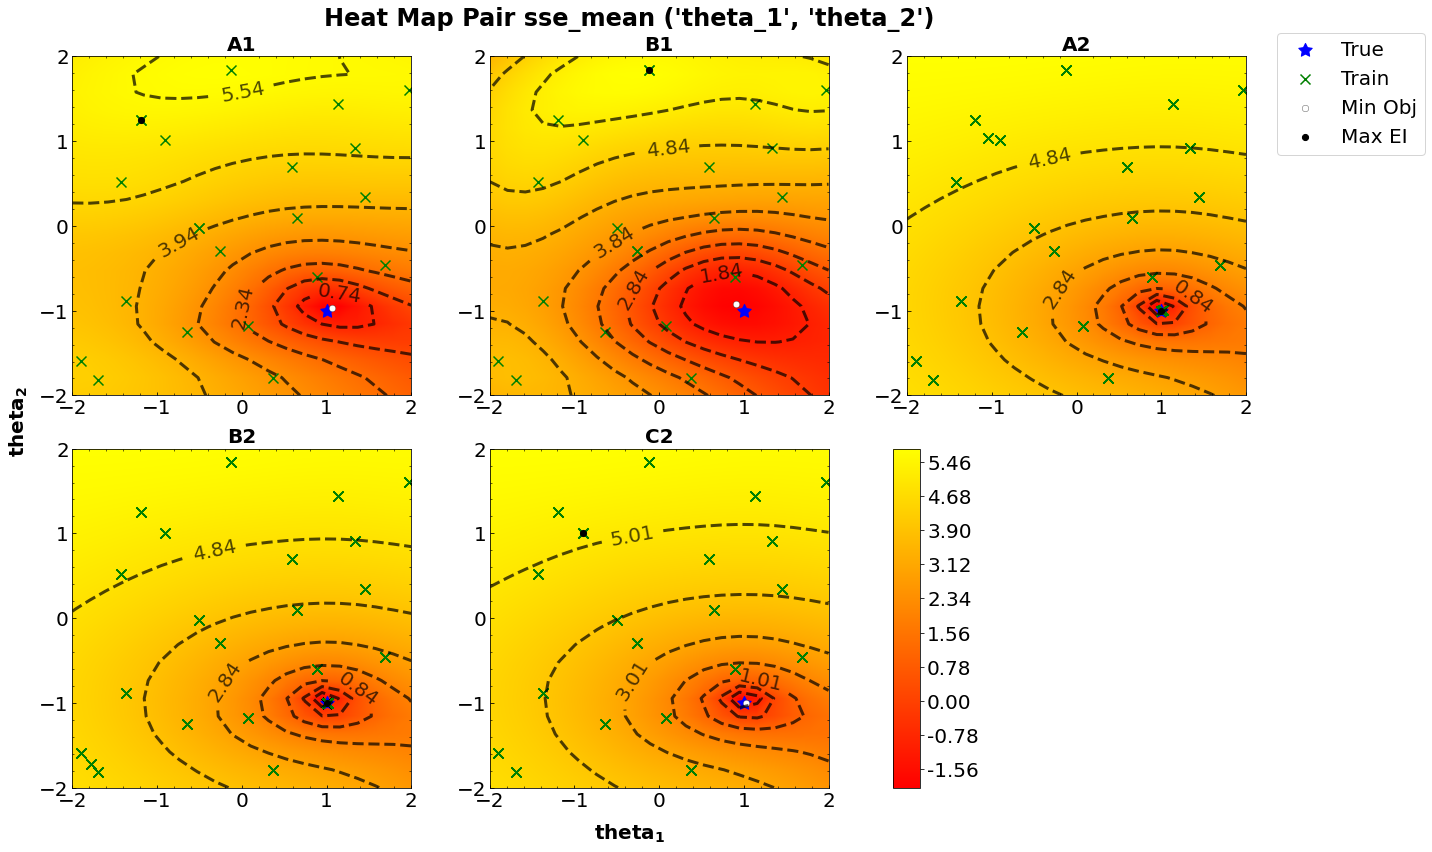

In [6]:
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_path = None
cmap = "autumn"
pair = 0
log_data = True

title = "Heat Map Pair "
z_choice = "sse_mean"
title = "Heat Map Pair " + z_choice
levels = [100,100,100, 100, 100]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))

meth_name_str_list = ["A1", "B1", "A2", "B2", "C2"]
pair = 0

compare_method_heat_maps(file_path_list, meth_name_str_list, run_num_list, bo_iter_list, pair, 
                         z_choice, log_data, levels, xbins, ybins, zbins, title, title_fontsize, other_fontsize, 
                         cmap, save_path)

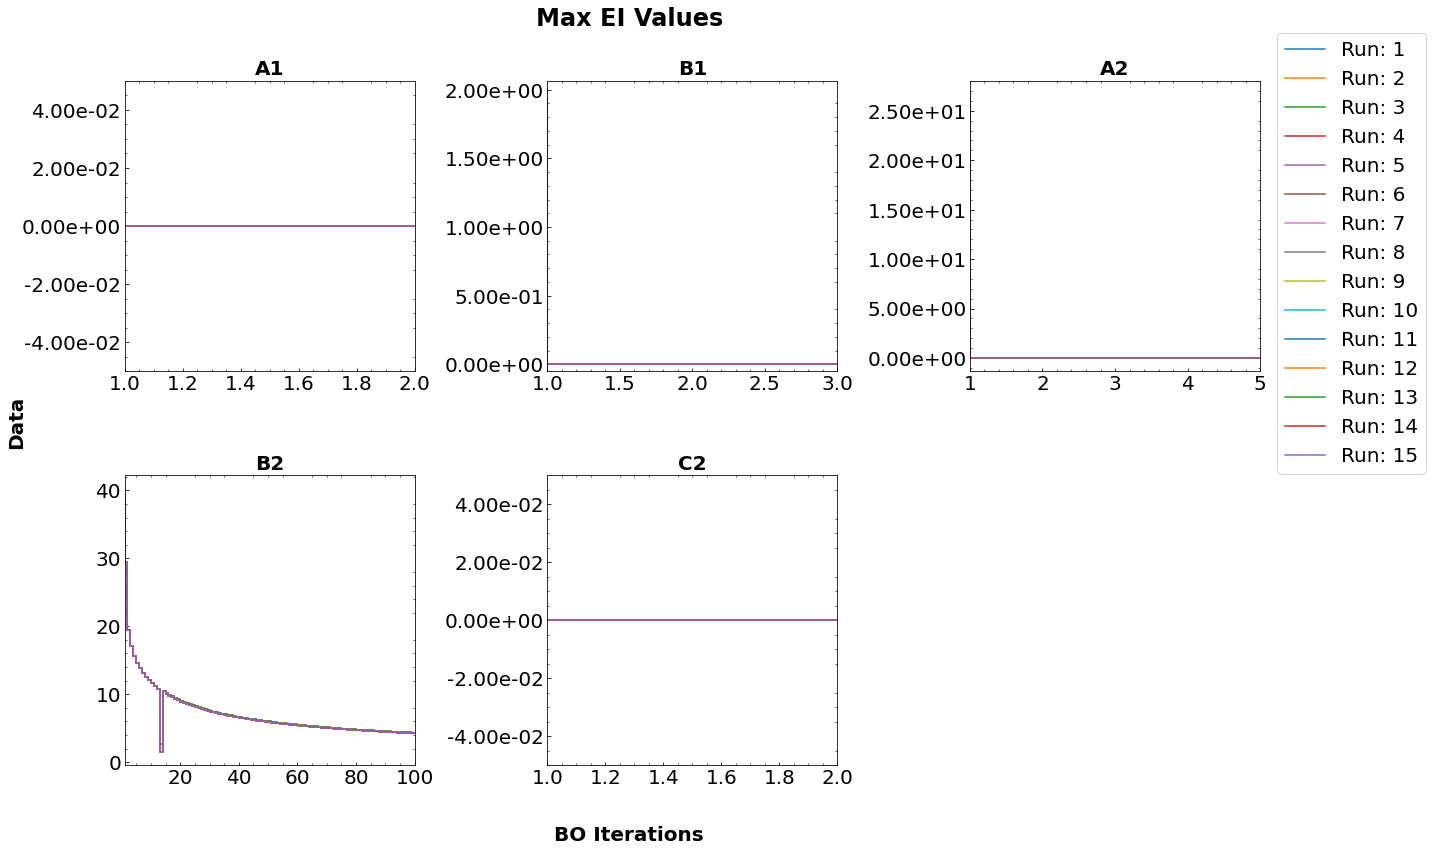

In [13]:
bo_method_list = ["A1", "B1", "A2", "B2", "C2" ]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
data_names = ["EI"]
string_for_df_theta = ["Max EI"]
# data_names = ["log(sse)", "min(log(sse))", "log(EI)"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = "Data"
title = "Max EI Values"
save_path = None
log_data = False

plot_compare_method_ei_sse(file_path_list, bo_method_list, run_num_list, string_for_df_theta, data_names, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

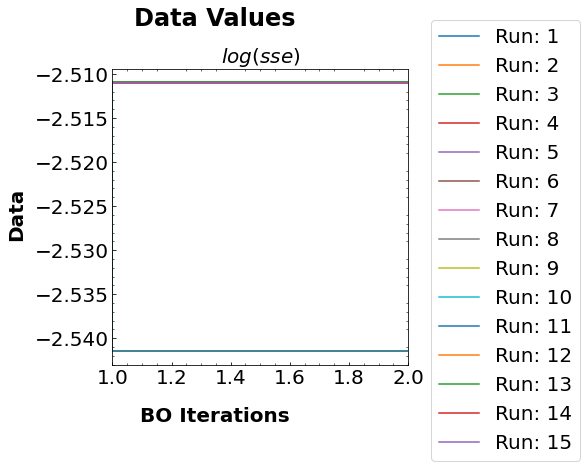

In [8]:
#Get sse, log_sse, and ei plots
file_path = "workspace/2b0d1ee15911cd245f17a7d10a7abf3e/BO_Results.gz" #CS1 A1 Best
# file_path = "workspace/b0e257d6e76025909e364903b3b792ee/BO_Results.gz" #CS1 B1 Best
# file_path = "workspace/d0c8b17229671998f3ffdab06c79e1f9/BO_Results.gz" #CS1 A2 Best
# file_path = "workspace/fdc2673ac83f3d0cf5b3b969a3e80825/BO_Results.gz" #CS1 B2 Best
# file_path = "workspace/9042085b58a00b76d6c2ae0a20cfe9f3/BO_Results.gz" #CS1 C2 Best
# file_path = date_time_str + "Data_Files/" + name_cs_str + "_BO_method_" + "C2" + "_sep_fact_0.9.gz"

loaded_results = open_file_helper(file_path)
meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name
run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
data_names = ["log(sse)"]
strings_for_df = ["Min Obj Cum."]
# data_names = ["log(sse)_{GP}", "log(sse)", "log(EI)"]
# strings_for_df = ["Min Obj", "Min Obj Cum.", "Max EI"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = "Data"
title = "Data Values"
save_path = None
log_data = True

data, data_true = analyze_sse_min_sse_ei(file_path, run_num, strings_for_df)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [11]:
#Get sse, log_sse, and ei plot files
import signac

file_path_list = ["2023/09/05/Data_Files/CS1_BO_method_A1_ep_method_CONSTANT.pickle",
                  "2023/09/05/Data_Files/CS1_BO_method_B1_ep_method_CONSTANT.pickle",
                  "2023/09/05/Data_Files/CS1_BO_method_A2_ep_method_CONSTANT.pickle",
                  "2023/09/05/Data_Files/CS1_BO_method_B2_ep_method_CONSTANT.pickle",
                  "2023/09/05/Data_Files/CS1_BO_method_C2_ep_method_CONSTANT.pickle"]

file_path_list = []
project = signac.get_project()
cs_name_val = 1
param_name_str = "t1t2"
meth_name_str_list = [1, 2, 3, 4, 5]

for meth_name_val in meth_name_str_list:
    meth_name = Method_name_enum(meth_name_val)
    cs_name_enum = CS_name_enum(cs_name_val) 
    #Get best ep data from Results path if possible
    path_name = "Results/ep_study/" + cs_name_enum.name + "/" + meth_name.name + "/ep_study_best.csv"
    if os.path.exists(path_name):
        df_ep_best = pd.read_csv(path_name, header = 0)
    #If there is no results path infer it directly from the jobs
    else:
        df_ep, cs_name, theta_true = get_study_data_signac(project, cs_name_val, param_name_str, meth_name_val, "ep", save_csv = False) 
        df_ep_best = get_best_data(df_ep, "ep", cs_name, theta_true, date_time_str = None, save_csv = False)

    #Set ep enum val to the best one for that cs and method
    best_ep_enum_val = int(df_ep_best["EP Method Val"].iloc[0])

    #Get all jobs with that ep enum val
    jobs = project.find_jobs({"cs_name_val": cs_name_val, "meth_name_val" : meth_name_val, "ep_enum_val": best_ep_enum_val, "sep_fact" : 1})
    for job in jobs:
        file_path_list.append(job.fn("BO_Results.gz"))